# GBDT baselines

- 작성일: 240108
- 작성자: 이주연

특이 사항
- 평가 데이터를 학습/평가 데이터 전처리에 사용함
- user, tag, item, test의 평균 정답률을 agg하여 사용함. 단 agg 시 label 데이터를 포함하지 않고 진행함.
- hyperparameter tuning 전혀 없이 default setting으로 진행. 단, categorical data는 명시.

In [1]:
import os, random
from datetime import datetime as dt
from string import ascii_lowercase

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

plt.rcParams["font.family"] = 'NanumGothic'

In [2]:
# project config
projectname = "dkt-gbdt"

# run config
modelname = input('input model name (XGBoost, LightGBM, CatBoost): ') # XGBoost, LightGBM, CatBoost
now = dt.strftime(dt.now(), '%y%m%d-%H%M%S')
randomcode = "".join(random.choices(ascii_lowercase, k=5)) # before fix random seed
runname = f'{modelname}_{now}_{randomcode}'
runname

'LightGBM_240123-161226_ewyzo'

In [3]:
embed = True
svd_embeddings = False

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)

### data load

In [5]:
data_dir = '../../../dkt/data'

In [6]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

train_df.shape, test_df.shape

((2266586, 6), (260114, 6))

In [7]:
import pickle

if embed:
    filename = 'svd-32_240117-181412_0.7931_embeddings.pickle'
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        data

In [8]:
if modelname == 'CatBoost' and embed and svd_embeddings:
    user_embedding_df = pd.DataFrame(
        [[user_id, user_embedding] for user_id, user_embedding in zip(data['user_ids'], data['user_embeddings'])], 
        columns=['userID', 'user_embedding'])
    item_embedding_df = pd.DataFrame(
        [[user_id, user_embedding] for user_id, user_embedding in zip(data['item_ids'], data['item_embeddings'])], 
        columns=['assessmentItemID', 'item_embedding'])
elif (modelname == 'LightGBM' or modelname == 'CatBoost') and embed:
    user_embedding_df = pd.DataFrame(
        data['user_embeddings'], index=data['user_ids'], 
        columns=[f'user_embed_{i}' for i in range(data['user_embeddings'].shape[1])])
    item_embedding_df = pd.DataFrame(
        data['item_embeddings'], index=data['item_ids'], 
        columns=[f'item_embed_{i}' for i in range(data['item_embeddings'].shape[1])])

## preprocessing

In [9]:
# # drop Timestamp
# train_df = train_df.drop(columns=['Timestamp'])
# test_df = test_df.drop(columns=['Timestamp'])

In [10]:
def filter_df(df, dataset_type, sampling_ratio=0.5):
    if dataset_type == 'last':
        df = df.drop_duplicates(subset=['userID'], keep='last')
    if dataset_type == 'sample':

        last_index = df.drop_duplicates(subset=['userID'], keep='last').index

        total_user_num = len(df.userID.unique())
        sampled_index = df.sample(int(total_user_num*sampling_ratio)).index

        sampling_index = np.unique(np.concatenate([sampled_index, last_index]))
        df = df.loc[sampling_index, :]#drop_duplicates(subset=['userID'], keep='last')

    return df

In [11]:
train_label = filter_df(train_df, 'last')#'sample', 0.5)#train_df.drop_duplicates(subset=['userID'], keep='last')
train_label.shape

(6698, 6)

In [12]:
# split label
train_last = train_df.drop_duplicates(subset=['userID'], keep='last')
test_label = test_df.drop_duplicates(subset=['userID'], keep='last')

# drop labels
train_df = train_df.drop(index=train_last.index)
test_df = test_df.drop(index=test_label.index)
base_df = pd.concat([train_df, test_df], axis=0)

base_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

문제 풀이 시간 전처리

그룹 정보 생성

In [14]:
# timediff of the last item of the testID is all 0
base_df[(base_df['userID'] == 0) & (base_df['testId']=='A060000001')]
base_df[(base_df['userID'] == 0) & (base_df['testId']=='A080000129')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
739,0,A080129001,A080000129,1,2020-12-23 03:35:32,2723
740,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723
741,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725
742,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725
743,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725


In [15]:
# to datetime
base_df['Timestamp'] = pd.to_datetime(base_df['Timestamp'])
# get consuming time to deal with the problem
base_df['timediff'] = (base_df['Timestamp']-base_df['Timestamp'].shift(1)
    ).dt.seconds.shift(-1)

# get the last item of the users
base_df['next_userID'] = base_df.userID.shift(-1)
last_appearances = base_df.apply(lambda x: True if x['userID']!=x['next_userID'] else False, axis=1)
base_df.loc[last_appearances, 'timediff'] = np.nan

# get to know last item of the tests
base_df['next_testId'] = base_df.testId.shift(-1)
last_appearances = base_df.apply(lambda x: True if x['testId']!=x['next_testId'] else False, axis=1)
base_df.loc[last_appearances, 'timediff'] = np.nan

# 1시간이 넘게 걸리면 문제가 있다고 본다.
base_df.loc[base_df.timediff > 3600, 'timediff'] = np.nan

In [16]:
# timediff of the last item of the testID is all 0
base_df[(base_df['userID'] == 0) & (base_df['testId']=='A060000001')]
base_df[(base_df['userID'] == 0) & (base_df['testId']=='A080000129')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,timediff,next_userID,next_testId
739,0,A080129001,A080000129,1,2020-12-23 03:35:32,2723,22.0,0.0,A080000129
740,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723,86.0,0.0,A080000129
741,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725,83.0,0.0,A080000129
742,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725,91.0,0.0,A080000129
743,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725,NaN,1.0,A040000013


In [17]:
scaling_cols = ['timediff']

In [18]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# standard scaling
scaler = StandardScaler()
scaler = scaler.fit(base_df[scaling_cols])
base_df[scaling_cols] = scaler.transform(base_df[scaling_cols])

In [19]:
########### 4. testID를 자른 값을 추가
# testID값을 분리한 값을 추가
base_df['test_group_one'] = base_df['testId'].apply(lambda x: int(x[1:4]))
base_df['test_group_two'] = base_df['testId'].apply(lambda x: int(x[-3:]))
########### 5. itemID에서 순번을 자른 값을 추가
# 과제의 순번이 영향이 있지 않을까
base_df['serial'] = base_df['assessmentItemID'].apply(lambda x: int(x[-3:]))

### aggregation

In [20]:
# agg
base_user_agg = base_df.groupby('userID').agg(
    user_acc_mean=('answerCode','mean'), 
    total_test=('answerCode','count'),
    user_acc_recent3=('answerCode', lambda x: x.tail(3).mean()), # head? tail?
    user_acc_recent5=('answerCode', lambda x: x.tail(5).mean()),
    user_acc_recent10=('answerCode', lambda x: x.tail(10).mean()),
    # last data
    user_previous=('answerCode', lambda x: x.tail(1)),
    # time
    user_time_median=('timediff','median'), 
    user_count=('answerCode','count'),
)
# base_df.groupby('userID').apply(lambda x: x.head(5)['answerCode'].mean())
base_user_agg['user_count'] = (base_user_agg['user_count']-base_user_agg['user_count'].mean())/base_user_agg['user_count'].max()
base_user_agg['user_ability'] = base_user_agg.user_acc_mean/(base_user_agg.user_time_median+1)
base_user_agg.head()

,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,user_acc_recent10,user_previous,user_time_median,user_count,user_ability
userID,,,,,,,,,
0,0.631720,744,0.333333,0.6,0.6,0,-0.283491,0.218118,0.881664
1,0.853004,932,1.000000,0.8,0.9,1,-0.021429,0.319247,0.871683
2,0.614545,275,0.000000,0.0,0.4,0,-0.238884,-0.034168,0.807427
3,0.692754,1035,0.666667,0.8,0.8,0,-0.222157,0.374654,0.890609
4,0.694030,670,1.000000,0.8,0.7,1,-0.144096,0.178311,0.810873


In [21]:
base_user_item_agg = base_df.groupby(['userID', 'assessmentItemID']).agg(
    ########### 6. 유저별로 이전에 동일한 문제를 풀었던 횟수를 추가
    # 동일한 과제를 수행했으면 다음번엔 맞출 확률이 높을 것
    user_solved_count=('answerCode', 'cumcount'),
)
base_user_item_agg = pd.concat(
    [base_user_item_agg, base_df[['userID', 'assessmentItemID']]], axis=1).drop_duplicates(
        ['userID', 'assessmentItemID'], keep='last')
base_user_item_agg.head()

,user_solved_count,userID,assessmentItemID
0,0,0,A060001001
1,0,0,A060001002
2,0,0,A060001003
3,0,0,A060001004
4,0,0,A060001005


In [22]:
base_tag_agg = base_df.groupby('KnowledgeTag').agg(
    tag_acc_mean=('answerCode','mean'),
    tag_time_median=('timediff','median'),
)
base_tag_agg['tag_difficulty'] = base_tag_agg.tag_acc_mean/(base_tag_agg.tag_time_median+1)
base_tag_agg.head()

,tag_acc_mean,tag_time_median,tag_difficulty
KnowledgeTag,,,
23,0.592593,-0.303006,0.850212
24,0.625000,-0.272339,0.858917
25,0.850000,-0.113429,0.958750
26,0.611193,-0.305794,0.880421
30,0.530000,-0.272339,0.728361


In [23]:
base_item_agg = base_df.groupby('assessmentItemID').agg(
    item_acc_mean=('answerCode','mean'),
    item_time_median=('timediff','median'),
)
base_item_agg['item_difficulty'] = base_item_agg.item_acc_mean/(base_item_agg.item_time_median+1)
base_item_agg.head()

,item_acc_mean,item_time_median,item_difficulty
assessmentItemID,,,
A010001001,0.922857,-0.294642,1.308353
A010001002,0.960000,-0.328097,1.428778
A010001003,0.905714,-0.238884,1.189982
A010001004,0.945714,-0.183127,1.157724
A010001005,0.882857,-0.224945,1.139090


In [24]:
base_test_agg = base_df.groupby('testId').agg(
    test_acc_mean=('answerCode','mean'),
    test_time_median=('timediff','median'),
)
base_test_agg['test_difficulty'] = base_test_agg.test_acc_mean/(base_test_agg.test_time_median+1)
base_test_agg.head()

,test_acc_mean,test_time_median,test_difficulty
testId,,,
A010000001,0.923429,-0.266763,1.259387
A010000002,0.931429,-0.283491,1.299953
A010000003,0.842857,-0.272339,1.158310
A010000004,0.880571,-0.300218,1.258351
A010000005,0.849143,-0.250036,1.132245


In [25]:
base_g1_agg = base_df.groupby('test_group_one').agg(
    g1_acc_mean=('answerCode','mean'),
    g1_time_median=('timediff','median'),
)
base_g1_agg['g1_difficulty'] = base_g1_agg.g1_acc_mean/(base_g1_agg.g1_time_median+1)

base_g2_agg = base_df.groupby('test_group_two').agg(
    g2_acc_mean=('answerCode','mean'),
    g2_time_median=('timediff','median'),
)
base_g2_agg['g2_difficulty'] = base_g2_agg.g2_acc_mean/(base_g2_agg.g2_time_median+1)

In [26]:
base_tabular = pd.merge(train_label, base_user_agg, left_on='userID', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_tag_agg, left_on='KnowledgeTag', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_item_agg, left_on='assessmentItemID', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_test_agg, left_on='testId', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_user_item_agg, right_on=['userID', 'assessmentItemID'], left_on=['userID', 'assessmentItemID'], how='left').fillna(0)
base_tabular.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,...,tag_acc_mean,tag_time_median,tag_difficulty,item_acc_mean,item_time_median,item_difficulty,test_acc_mean,test_time_median,test_difficulty,user_solved_count
0,0,A080129006,A080000129,0,2020-12-23 03:40:19,2725,0.631720,744,0.333333,0.6,...,0.303871,-0.367127,0.480146,0.156593,-0.378279,0.251871,0.362708,-0.350400,0.558355,0.0
1,1,A090074006,A090000074,1,2020-11-13 02:47:20,2648,0.853004,932,1.000000,0.8,...,0.451737,-0.339249,0.683672,0.478261,-0.269551,0.654749,0.436567,-0.316945,0.639139,0.0
2,2,A050139007,A050000139,0,2020-10-20 11:32:26,428,0.614545,275,0.000000,0.0,...,0.678480,-0.216581,0.866051,0.125000,0.098451,0.113797,0.626797,-0.227733,0.811632,0.0
3,5,A080138007,A080000138,1,2020-12-11 22:48:28,8431,0.795673,832,0.333333,0.2,...,0.472861,-0.350400,0.727927,0.554622,-0.350400,0.853790,0.499468,-0.333673,0.749584,0.0
4,6,A030145005,A030000145,0,2020-10-26 09:52:14,7817,0.443478,920,0.000000,0.2,...,0.616850,-0.077187,0.668445,0.615120,-0.093914,0.678876,0.627767,-0.138520,0.728707,0.0


In [27]:
########### 4. testID를 자른 값을 추가
# testID값을 분리한 값을 추가
base_tabular['test_group_one'] = base_tabular['testId'].apply(lambda x: int(x[1:4]))
base_tabular['test_group_two'] = base_tabular['testId'].apply(lambda x: int(x[-3:]))
########### 5. itemID에서 순번을 자른 값을 추가
# 과제의 순번이 영향이 있지 않을까
base_tabular['serial'] = base_tabular['assessmentItemID'].apply(lambda x: int(x[-3:]))

In [28]:
# train merge
train_tabular = train_label
train_tabular = pd.merge(train_label, base_user_agg, left_on='userID', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_tag_agg, left_on='KnowledgeTag', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_item_agg, left_on='assessmentItemID', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_test_agg, left_on='testId', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_user_item_agg, right_on=['userID', 'assessmentItemID'], left_on=['userID', 'assessmentItemID'], how='left')
train_tabular.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,...,tag_acc_mean,tag_time_median,tag_difficulty,item_acc_mean,item_time_median,item_difficulty,test_acc_mean,test_time_median,test_difficulty,user_solved_count
0,0,A080129006,A080000129,0,2020-12-23 03:40:19,2725,0.631720,744,0.333333,0.6,...,0.303871,-0.367127,0.480146,0.156593,-0.378279,0.251871,0.362708,-0.350400,0.558355,NaN
1,1,A090074006,A090000074,1,2020-11-13 02:47:20,2648,0.853004,932,1.000000,0.8,...,0.451737,-0.339249,0.683672,0.478261,-0.269551,0.654749,0.436567,-0.316945,0.639139,NaN
2,2,A050139007,A050000139,0,2020-10-20 11:32:26,428,0.614545,275,0.000000,0.0,...,0.678480,-0.216581,0.866051,0.125000,0.098451,0.113797,0.626797,-0.227733,0.811632,NaN
3,5,A080138007,A080000138,1,2020-12-11 22:48:28,8431,0.795673,832,0.333333,0.2,...,0.472861,-0.350400,0.727927,0.554622,-0.350400,0.853790,0.499468,-0.333673,0.749584,NaN
4,6,A030145005,A030000145,0,2020-10-26 09:52:14,7817,0.443478,920,0.000000,0.2,...,0.616850,-0.077187,0.668445,0.615120,-0.093914,0.678876,0.627767,-0.138520,0.728707,NaN


In [29]:
if modelname == 'CatBoost' and embed and svd_embeddings:
    train_tabular = pd.merge(train_tabular, user_embedding_df, left_on='userID', right_on='userID', how='left')
    train_tabular = pd.merge(train_tabular, item_embedding_df, left_on='assessmentItemID', right_on='assessmentItemID', how='left')

elif (modelname == 'LightGBM' or modelname == 'CatBoost') and embed:
    train_tabular = pd.merge(train_tabular, user_embedding_df, left_on='userID', right_index=True, how='left')
    train_tabular = pd.merge(train_tabular, item_embedding_df, left_on='assessmentItemID', right_index=True, how='left')
    
train_tabular.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,...,tag_acc_mean,tag_time_median,tag_difficulty,item_acc_mean,item_time_median,item_difficulty,test_acc_mean,test_time_median,test_difficulty,user_solved_count
0,0,A080129006,A080000129,0,2020-12-23 03:40:19,2725,0.631720,744,0.333333,0.6,...,0.303871,-0.367127,0.480146,0.156593,-0.378279,0.251871,0.362708,-0.350400,0.558355,NaN
1,1,A090074006,A090000074,1,2020-11-13 02:47:20,2648,0.853004,932,1.000000,0.8,...,0.451737,-0.339249,0.683672,0.478261,-0.269551,0.654749,0.436567,-0.316945,0.639139,NaN
2,2,A050139007,A050000139,0,2020-10-20 11:32:26,428,0.614545,275,0.000000,0.0,...,0.678480,-0.216581,0.866051,0.125000,0.098451,0.113797,0.626797,-0.227733,0.811632,NaN
3,5,A080138007,A080000138,1,2020-12-11 22:48:28,8431,0.795673,832,0.333333,0.2,...,0.472861,-0.350400,0.727927,0.554622,-0.350400,0.853790,0.499468,-0.333673,0.749584,NaN
4,6,A030145005,A030000145,0,2020-10-26 09:52:14,7817,0.443478,920,0.000000,0.2,...,0.616850,-0.077187,0.668445,0.615120,-0.093914,0.678876,0.627767,-0.138520,0.728707,NaN


In [30]:
########### 4. testID를 자른 값을 추가
# testID값을 분리한 값을 추가
train_tabular['test_group_one'] = train_tabular['testId'].apply(lambda x: int(x[1:4])).astype(int)
train_tabular['test_group_two'] = train_tabular['testId'].apply(lambda x: int(x[-3:])).astype(int)
########### 5. itemID에서 순번을 자른 값을 추가
# 과제의 순번이 영향이 있지 않을까
train_tabular['serial'] = train_tabular['assessmentItemID'].apply(lambda x: int(x[-3:])).astype(int)

train_tabular = pd.merge(train_tabular, base_g1_agg, left_on='test_group_one', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_g2_agg, left_on='test_group_two', right_index=True, how='left')

In [31]:
# train merge
test_tabular = test_label
test_tabular = pd.merge(test_label, base_user_agg, left_on='userID', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_tag_agg, left_on='KnowledgeTag', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_item_agg, left_on='assessmentItemID', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_test_agg, left_on='testId', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_user_item_agg, right_on=['userID', 'assessmentItemID'], left_on=['userID', 'assessmentItemID'], how='left')
test_tabular.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,...,tag_acc_mean,tag_time_median,tag_difficulty,item_acc_mean,item_time_median,item_difficulty,test_acc_mean,test_time_median,test_difficulty,user_solved_count
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,0.692754,1035,0.666667,0.8,...,0.559729,-0.116217,0.633333,0.536290,-0.294642,0.760310,0.655656,-0.155248,0.776151,NaN
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,0.694030,670,1.000000,0.8,...,0.548426,-0.316945,0.802902,0.605839,-0.367127,0.957285,0.651477,-0.171975,0.786784,NaN
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,0.695289,1316,0.333333,0.4,...,0.495308,-0.339249,0.749614,0.369478,-0.375491,0.591630,0.456957,-0.355976,0.709534,NaN
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,0.818904,1259,1.000000,1.0,...,0.422518,-0.361552,0.661789,0.274725,-0.328097,0.408876,0.449915,-0.339249,0.680914,NaN
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,0.759067,386,0.333333,0.6,...,0.611052,-0.188702,0.753179,0.315126,-0.252824,0.421756,0.642693,-0.233309,0.838268,NaN


In [32]:
if modelname == 'CatBoost' and embed and svd_embeddings:
    test_tabular = pd.merge(test_tabular, user_embedding_df, left_on='userID', right_on='userID', how='left')
    test_tabular = pd.merge(test_tabular, item_embedding_df, left_on='assessmentItemID', right_on='assessmentItemID', how='left')

elif (modelname == 'LightGBM' or modelname == 'CatBoost') and embed:
    test_tabular = pd.merge(test_tabular, user_embedding_df, left_on='userID', right_index=True, how='left')
    test_tabular = pd.merge(test_tabular, item_embedding_df, left_on='assessmentItemID', right_index=True, how='left')

test_tabular.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,...,tag_acc_mean,tag_time_median,tag_difficulty,item_acc_mean,item_time_median,item_difficulty,test_acc_mean,test_time_median,test_difficulty,user_solved_count
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,0.692754,1035,0.666667,0.8,...,0.559729,-0.116217,0.633333,0.536290,-0.294642,0.760310,0.655656,-0.155248,0.776151,NaN
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,0.694030,670,1.000000,0.8,...,0.548426,-0.316945,0.802902,0.605839,-0.367127,0.957285,0.651477,-0.171975,0.786784,NaN
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,0.695289,1316,0.333333,0.4,...,0.495308,-0.339249,0.749614,0.369478,-0.375491,0.591630,0.456957,-0.355976,0.709534,NaN
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,0.818904,1259,1.000000,1.0,...,0.422518,-0.361552,0.661789,0.274725,-0.328097,0.408876,0.449915,-0.339249,0.680914,NaN
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,0.759067,386,0.333333,0.6,...,0.611052,-0.188702,0.753179,0.315126,-0.252824,0.421756,0.642693,-0.233309,0.838268,NaN


In [33]:
########### 4. testID를 자른 값을 추가
# testID값을 분리한 값을 추가
test_tabular['test_group_one'] = test_tabular['testId'].apply(lambda x: int(x[1:4])).astype(int)
test_tabular['test_group_two'] = test_tabular['testId'].apply(lambda x: int(x[-3:])).astype(int)
########### 5. itemID에서 순번을 자른 값을 추가
# 과제의 순번이 영향이 있지 않을까
test_tabular['serial'] = test_tabular['assessmentItemID'].apply(lambda x: int(x[-3:])).astype(int)

test_tabular = pd.merge(test_tabular, base_g1_agg, left_on='test_group_one', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_g2_agg, left_on='test_group_two', right_index=True, how='left')

In [34]:
train_tabular['Timestamp'] = pd.to_datetime(train_tabular['Timestamp'])
test_tabular['Timestamp'] = pd.to_datetime(test_tabular['Timestamp'])

# 요일
train_tabular['dayofweek'] = train_tabular['Timestamp'].dt.dayofweek
test_tabular['dayofweek'] = test_tabular['Timestamp'].dt.dayofweek

# 시간대
train_tabular['time_hour'] = train_tabular['Timestamp'].dt.hour//4
test_tabular['time_hour'] = test_tabular['Timestamp'].dt.hour//4

In [35]:
# astype categorical data
category_columns = ['assessmentItemID', 'testId', 'KnowledgeTag', 
                    'test_group_one', 'test_group_two', 'serial',
                    # 'day_name'
                    ]#, 'test_class', 'item_number']
embedding_columns = ['user_embedding', 'item_embedding']

train_tabular[category_columns] = train_tabular[category_columns].astype("category")
test_tabular[category_columns] = test_tabular[category_columns].astype("category")

In [36]:
# drop Timestamp
train_tabular = train_tabular.drop(columns=['Timestamp', 'userID'])
test_tabular = test_tabular.drop(columns=['Timestamp', 'userID'])

In [37]:
train_tabular

,assessmentItemID,testId,answerCode,KnowledgeTag,user_acc_mean,total_test,user_acc_recent3,user_acc_recent5,user_acc_recent10,user_previous,...,test_group_two,serial,g1_acc_mean,g1_time_median,g1_difficulty,g2_acc_mean,g2_time_median,g2_difficulty,dayofweek,time_hour
0,A080129006,A080000129,0,2725,0.631720,744,0.333333,0.6,0.6,0,...,129,6,0.501257,-0.350400,0.771639,0.594179,-0.250036,0.792277,2,0
1,A090074006,A090000074,1,2648,0.853004,932,1.000000,0.8,0.9,1,...,74,6,0.454763,-0.367127,0.718569,0.686136,-0.216581,0.875823,4,0
2,A050139007,A050000139,0,428,0.614545,275,0.000000,0.0,0.4,0,...,139,7,0.659518,-0.211005,0.835897,0.679168,-0.255612,0.912384,1,2
3,A080138007,A080000138,1,8431,0.795673,832,0.333333,0.2,0.2,0,...,138,7,0.501257,-0.350400,0.771639,0.690946,-0.244460,0.914507,4,5
4,A030145005,A030000145,0,7817,0.443478,920,0.000000,0.2,0.5,0,...,145,5,0.702729,-0.227733,0.909955,0.776472,-0.289066,1.092186,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6693,A030019001,A030000019,0,331,0.500000,14,0.666667,0.6,0.3,1,...,19,1,0.702729,-0.227733,0.909955,0.615005,-0.289066,0.865067,2,3
6694,A060003007,A060000003,0,7226,0.400000,15,0.333333,0.2,0.2,1,...,3,7,0.712771,-0.227733,0.922959,0.627190,-0.266763,0.855371,4,0
6695,A030188005,A030000188,1,1934,0.733333,15,0.666667,0.8,0.7,1,...,188,5,0.702729,-0.227733,0.909955,0.786065,-0.272339,1.080262,0,2
6696,A030197005,A030000197,0,1984,0.428571,14,0.000000,0.2,0.4,0,...,197,5,0.702729,-0.227733,0.909955,0.754682,-0.272339,1.037134,2,2


In [38]:
# define X, y data
X_train = train_tabular.drop(columns='answerCode')
y_train = train_tabular[['answerCode']]

X_test = test_tabular.drop(columns='answerCode')

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698 entries, 0 to 6697
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   assessmentItemID   6698 non-null   category
 1   testId             6698 non-null   category
 2   KnowledgeTag       6698 non-null   category
 3   user_acc_mean      6698 non-null   float64 
 4   total_test         6698 non-null   int64   
 5   user_acc_recent3   6698 non-null   float64 
 6   user_acc_recent5   6698 non-null   float64 
 7   user_acc_recent10  6698 non-null   float64 
 8   user_previous      6698 non-null   int64   
 9   user_time_median   6698 non-null   float64 
 10  user_count         6698 non-null   float64 
 11  user_ability       6698 non-null   float64 
 12  tag_acc_mean       6698 non-null   float64 
 13  tag_time_median    6698 non-null   float64 
 14  tag_difficulty     6698 non-null   float64 
 15  item_acc_mean      6698 non-null   float64 
 16  item_t

In [40]:
# plt.hist(X_train.time_hour)
# plt.hist(X_train.dayofweek)

# log transform
X_train.total_test = np.log1p(X_train.total_test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X_train[['total_test', 'time_hour', 'dayofweek']])
# X_train.describe()

## train/valid split

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, shuffle=True)

X_train.shape, X_valid.shape

((5358, 33), (1340, 33))

## train GBDT with default setting

In [43]:

# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project=projectname,
    name=runname,
    # track hyperparameters and run metadata
    config={
    "learning_rate": 'None',
    "modelname": modelname,
    "dataset": "dkt-agg",
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: twndus (dkt-recsys1). Use `wandb login --relogin` to force relogin


In [44]:
from xgboost import XGBClassifier
from wandb.xgboost import WandbCallback as WandbCallbackXGB

import lightgbm as lgb
from wandb.lightgbm import wandb_callback, log_summary

from catboost import CatBoostClassifier
from wandb.catboost import WandbCallback as WandbCallbackCatBoost

In [45]:
if modelname == 'XGBoost':
    # create model instance
    model = XGBClassifier(
        objective='binary:logistic',
        enable_categorical=True,
        early_stopping_rounds=40, # early stopping
        callbacks=[WandbCallbackXGB(log_model=True)],
        )
    # fit model
    model = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    
    # get best iter
    best_iter = model.get_booster().best_iteration

elif modelname == 'LightGBM':
    # prep dataset
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature='auto')
    lgb_valid = lgb.Dataset(X_valid, y_valid, categorical_feature='auto')
    # create model instance
    param = {
        'objective': 'binary', 'metric': 'auc',
        'bagging_fraction':.8,
        'stopping_rounds':40 # early stopping
        }
    # fit model
    model = lgb.train(
        param, lgb_train,
        valid_sets=[lgb_valid],
        callbacks=[wandb_callback()],
        num_boost_round=5,
    )
    best_iter = model.best_iteration

    # # Log feature importance plot and upload model checkpoint to W&B
    # log_summary(model, save_model_checkpoint=True)

elif modelname == 'CatBoost':
    # define model
    model = CatBoostClassifier(
        custom_loss='AUC',
        logging_level='Verbose',
        od_type='Iter',
        od_wait=40, # early stopping
        )

    # fit model
    if not svd_embeddings: embedding_columns = None
    model = model.fit(
        X_train, y_train,
        cat_features=category_columns,
        embedding_features=embedding_columns,
        eval_set=(X_valid, y_valid),
        logging_level='Verbose',  # you can uncomment this for text output
        use_best_model=True, # user best model
        callbacks=[WandbCallbackCatBoost()],
    )
else:
    raise ValueError(
        f"{modelname} not found. Please specify the model name as one of the following: 'XGBoost', 'LightGBM', 'CatBoost'.")

[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Info] Number of positive: 2571, number of negative: 2787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4998
[LightGBM] [Info] Number of data points in the train set: 5358, number of used features: 33
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479843 -> initscore=-0.080671
[LightGBM] [Info] Start training from score -0.080671


## evaluation by validation data

In [46]:
if modelname == 'XGBoost':
    # predict proba
    train_pred_proba = model.predict_proba(X_train, iteration_range=(0, best_iter+1))[:,1]
    valid_pred_proba = model.predict_proba(X_valid, iteration_range=(0, best_iter+1))[:,1]
    test_pred_proba = model.predict_proba(X_test, iteration_range=(0, best_iter+1))[:,1]

elif modelname == 'CatBoost':
    # predict proba
    train_pred_proba = model.predict_proba(X_train)[:,1]
    valid_pred_proba = model.predict_proba(X_valid)[:,1]
    test_pred_proba = model.predict_proba(X_test)[:,1]
    
elif modelname == 'LightGBM':
    # predict proba
    train_pred_proba = model.predict(X_train, num_iteration=best_iter)
    valid_pred_proba = model.predict(X_valid, num_iteration=best_iter)
    test_pred_proba = model.predict(X_test, num_iteration=best_iter)

# pred class
train_pred = train_pred_proba > 0.5
valid_pred = valid_pred_proba > 0.5
test_pred = test_pred_proba > 0.5

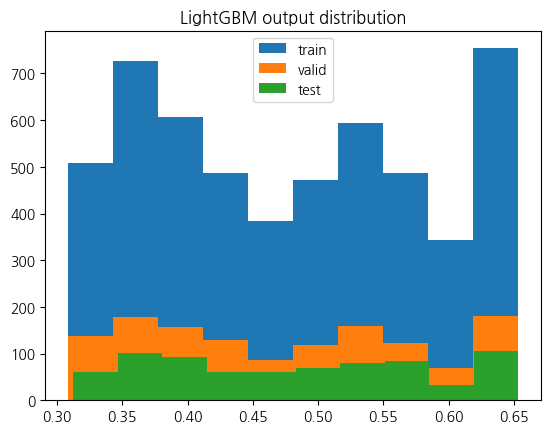

In [47]:
# predict proba histogram
plt.hist(train_pred_proba, label='train')
plt.hist(valid_pred_proba, label='valid')
plt.hist(test_pred_proba, label='test')
plt.legend()
plt.title(f'{modelname} output distribution')
plt.show()

### get optimal threshold with auroc curve

In [48]:
from sklearn.metrics import roc_curve, auc
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_valid, valid_pred_proba)
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.46262955211463425

In [49]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [50]:
train_acc = accuracy_score(y_train, train_pred)
valid_acc = accuracy_score(y_valid, valid_pred)
train_auc = roc_auc_score(y_train, train_pred_proba)
valid_auc = roc_auc_score(y_valid, valid_pred_proba)

print(f'train acc: {train_acc:.4f}, train AUC: {train_auc:.4f}')
print(f'valid acc: {valid_acc:.4f}, valid AUC: {valid_auc:.4f}')

train acc: 0.7544, train AUC: 0.8365
valid acc: 0.7306, valid AUC: 0.8016


In [51]:
run.log({
    "final_train_acc": train_acc,
    "final_valid_acc": valid_acc,
    "final_train_auc": train_auc,
    "final_valid_auc": valid_auc,
})

with default settings

- XGBoost (early stopping 40)
   - train acc: 0.7501, train AUC: 0.8318
   - valid acc: 0.6418, valid AUC: 0.7081
- XGBoost (no early stopping, overfitted)
   - train acc: 0.9793, train AUC: 0.9972
   - valid acc: 0.6313, valid AUC: 0.6911
- LightGBM (early stopping 40 == no early stopping, slightly overfitted)
   - train acc: 0.8457, train AUC: 0.9285
   - valid acc: 0.6433, valid AUC: 0.7143
- CatBoost (early stopping iter 40)
   - train acc: 0.7004, train AUC: 0.7773
   - valid acc: 0.6888, valid AUC: 0.7507

## understand the results

### confusion matrix

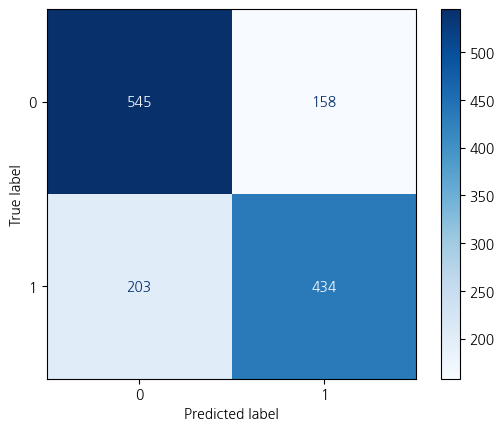

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cmd = ConfusionMatrixDisplay(confusion_matrix(y_valid, valid_pred))
cmd.plot(cmap='Blues', ax=ax)
plt.show()

In [53]:
run.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=np.squeeze(y_valid.values, axis=1), preds=valid_pred.astype(int),
        class_names=['0', '1'])})

### feature importance

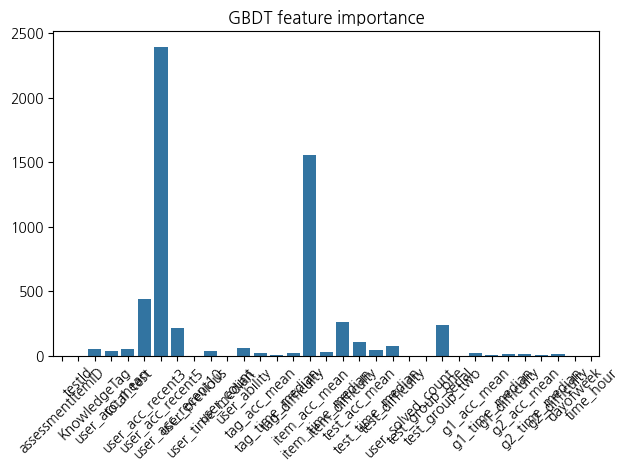

In [54]:
fig, ax = plt.subplots()
if modelname == 'XGBoost':
    importance = model.feature_importances_
    barplot = sns.barplot(importance, ax=ax)
    barplot.set_xticks(range(len(X_train.columns)))
    barplot.set_xticklabels(X_train.columns, rotation=45)
    
elif modelname == 'LightGBM':
    importance = model.feature_importance('gain')
    barplot = sns.barplot(importance, ax=ax)
    barplot.set_xticks(range(len(X_train.columns)))
    barplot.set_xticklabels(X_train.columns, rotation=45)
    
elif modelname == 'CatBoost':
    importance = model.get_feature_importance()
    barplot = sns.barplot(importance, ax=ax)
    barplot.set_xticks(range(len(X_train.columns)))
    barplot.set_xticklabels(X_train.columns, rotation=45)

plot_title = f'GBDT feature importance'
ax.set_title(plot_title)
plt.tight_layout()
plt.show()

In [55]:
# wandb plotting
xy_labels = ["feature names", "importance"]
data = pd.DataFrame([X_train.columns, importance]).T
data.columns = xy_labels
data.importance /= sum(data.importance)
table = wandb.Table(columns=xy_labels, data=data)

run.log({"feature importance plot" : wandb.plot.bar(
    table, *xy_labels, title=plot_title)})

In [56]:
# finish wandb run
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


final_train_acc,▁
final_train_auc,▁
final_valid_acc,▁
final_valid_auc,▁
iteration,▁▃▅▆█
valid_0_auc,▁▁▇▇█
final_train_acc,0.75439
final_train_auc,0.83652
final_valid_acc,0.7306
final_valid_auc,0.80157
iteration,4


## save submissions

In [57]:
submission_df.prediction = test_pred_proba

In [58]:
result_dir = '../results/'
savename = f'{modelname}_{now}_{randomcode}_{valid_auc:.4f}.csv'
submission_df.to_csv(os.path.join(result_dir, savename), index=False)

In [59]:
savename

'LightGBM_240123-161226_ewyzo_0.8016.csv'